## Analysis of Flight Data

### Introduction

Travelling by flight is one of the fastest ways of reaching destinations that are far away. Worldwide, it is the third most widely used mode of transport. But as the volume of air travel grows, so does the list of problems, the most significant of which is a flight delay. While it may not seem like much, a flight delay can cause a lot of issues to not only passengers but the airline operators as well. The concept of 'value of time' is of significance here for both parties and delays can severely affect that. In short, the value of time refers to how much a person can save on time when everything is done on a timely basis. However, delays can cause a hindrance in this. For example, if we assume $47 per hour* is the average value of a passenger's time, flight delays can cost air travelers billions of dollars (Source - https://www.airlines.org/dataset/per-minute-cost-of-delays-to-u-s-airlines/#). 

It is important to find the cause behind the delay to find a solution for it. In this research, this is exactly what we will be doing. We have a set of data with various attributes related to flights and air travel. We will be using this data to answer our research questions. 

We will begin by importing the data.

In [6]:
import pandas as pd

filename = "https://raw.githubusercontent.com/jtopor/DAV-5400/master/Project1/hflights.csv"
airlines = pd.read_csv(filename)
print(airlines)

       Year  Month  DayofMonth  DayOfWeek  DepTime  ArrTime UniqueCarrier  \
0      2011      1           1          6   1400.0   1500.0            AA   
1      2011      1           2          7   1401.0   1501.0            AA   
2      2011      1           3          1   1352.0   1502.0            AA   
3      2011      1           4          2   1403.0   1513.0            AA   
4      2011      1           5          3   1405.0   1507.0            AA   
...     ...    ...         ...        ...      ...      ...           ...   
19995  2011      2          25          5   1126.0   1333.0            CO   
19996  2011      2          25          5    941.0   1111.0            CO   
19997  2011      2          25          5    722.0    948.0            CO   
19998  2011      2          25          5   1909.0   2216.0            CO   
19999  2011      2          25          5   1255.0   1553.0            CO   

       FlightNum TailNum  ActualElapsedTime  ...  ArrDelay  DepDelay  Origi

#### With the given data, we will now be analyzing the cause of delays for these flights. This will be done based on three parameters:

- Origin and Destination airports
- Day of the week
- Unique carrier

But first, we will extract all the columns from the main data for our analysis, which is given below. This table will give us a summary of the required data. I'll be using this table only as a reference, as I've used data from the main table (airlines) for further coding.

In [28]:
# Creating a seperate table of required headings (for reference purpose only)
del_air = airlines[["DayOfWeek","DepDelay","ArrDelay","Origin","Dest","UniqueCarrier"]]
del_air.head(10)

,DayOfWeek,DepDelay,ArrDelay,Origin,Dest,UniqueCarrier
0,6,0.0,-10.0,IAH,DFW,AA
1,7,1.0,-9.0,IAH,DFW,AA
2,1,-8.0,-8.0,IAH,DFW,AA
3,2,3.0,3.0,IAH,DFW,AA
4,3,5.0,-3.0,IAH,DFW,AA
5,4,-1.0,-7.0,IAH,DFW,AA
6,5,-1.0,-1.0,IAH,DFW,AA
7,6,-5.0,-16.0,IAH,DFW,AA
8,7,43.0,44.0,IAH,DFW,AA
9,1,43.0,43.0,IAH,DFW,AA


### Delay Analysis

The next step is to do a thorough delay analysis for both departure and arrival. For this, we will be using the 'describe' command to get information regarding their mean, median, maximum and minimum values. This is to get the initial understanding of what kind of data I'm dealing with.

- Positive values indicate delayed departure/arrival
- Negative values indicate prompt departure/arrival

In [29]:
# for departure
d = airlines['DepDelay'].describe()
print('departure delay:', d)
print()

# for arrival
a = airlines['ArrDelay'].describe()
print('arrival delay:', a)

departure delay: count    19785.000000
mean         8.297700
std         23.934218
min        -18.000000
25%         -3.000000
50%          1.000000
75%         10.000000
max        780.000000
Name: DepDelay, dtype: float64

arrival delay: count    19738.000000
mean         5.205340
std         25.383494
min        -49.000000
25%         -8.000000
50%          0.000000
75%         11.000000
max        775.000000
Name: ArrDelay, dtype: float64


As seen above, the mean departure delay is around 8 mins, and the median is of 1 minute. On the other hand, the mean arrival delay is 5 mins, but the median is 0 minutes. This suggests that most flights do arrive at their expected time of arrival.

We will now plot this on a graph to get further clarification.

Text(0, 0.5, 'frequency of delay')

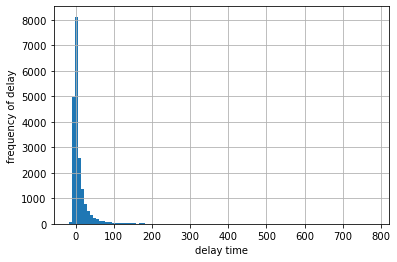

In [30]:
# plotting histogram
dh = airlines['DepDelay'].hist(bins=100)
dh.set_xlabel("delay time")
dh.set_ylabel("frequency of delay")

The curve looks centered around the mean 8.29 with a strong right skew as seen in the figure above. There appears to be at least 1 outlier as the histogram ends at 800. This can also be confirmed by the summary stats where the maximum value is 780.

Similarly, we'll plot one for arrival delays too.

Text(0, 0.5, 'frequency of delay')

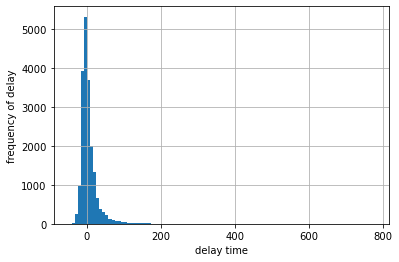

In [31]:
ah = airlines['ArrDelay'].hist(bins=100)
ah.set_xlabel("delay time")
ah.set_ylabel("frequency of delay")
# arrival delay is lower than departure delay.

The curve looks centered around the mean 0 with a similar right skew as the departure delay. This can also be confirmed by the summary stats where the maximum value is 775.

Now that we have a summary, we can make our first observation
- the arrival delay is less than the departure delay.

Other than that, there is not much we can find out. Hence, we will now move on to testing the parameters.

### Testing 'Origin' / 'Destination' delays

In this, we will be checking whether the location from where the flight takes off or lands has any effect on the delays. The first step would be to identify how many origin and destination airports are there. For that, we simply count the unique values in the 'Origin' and 'Dest' column of the data.

In [30]:
# origin/destination delays

print("There are {} unique origin airport".format(airlines['Origin'].nunique()))
print("There are {} unique destination airport".format(airlines['Dest'].nunique()))

There are 2 unique origin airport
There are 106 unique destination airport


Both IAH and HOU are airports based in Houston, TX. Hence, we can clearly say that all flights originate from Houston and travel to various destinations.

We can now start sorting the origin and destination airports in terms of delay rates. This is to find out if any particular airport plays any role in delays. For this, we will first count the average number of flights for departure locations, and then follow it up by finding the mean delay and the number of flights corresponding to the individual airports.

In [6]:
# Sorting the origins and destinations in terms of delay rate.

# average flights departing the airports
om = airlines.Origin.value_counts().mean()
print (om) 

# finding the mean delay and the number of flights seperately for each airport
od = airlines[['Origin','DepDelay']].groupby('Origin').agg(['mean','count'])
od.columns = ['mean delay','count of flights']
od.head()

10000.0


,mean delay,count of flights
Origin,,
HOU,13.452023,4252
IAH,6.886757,15533


The average number of flights per airport is 1000 per day. HOU, which has around 4200 also has a high delay rate as compared to IAH which seems to be doing great despite handling flights at a far larger volume than HOU.

We will now perform the same for arrival airports.

In [7]:
# average flights arriving at the airports
dm = airlines.Dest.value_counts().mean()
print (dm)

# finding the mean delay and the number of flights seperately for each airport
dd = airlines[['Dest','ArrDelay']].groupby('Dest').agg(['mean','count'])
dd.columns = ['mean delay','count of flights']
dd.head(106)

188.67924528301887


,mean delay,count of flights
Dest,,
ABQ,6.098814,253
AEX,0.396825,63
AMA,1.186916,107
ASE,2.576923,26
ATL,4.756014,582
...,...,...
TUL,5.059524,336
TUS,0.355932,118
TYS,3.230769,78


Since the data is too large to be analyzed by simply looking at it, we will instead plot a scatter plot to help us analyze it easily

<AxesSubplot:xlabel='count of flights'>

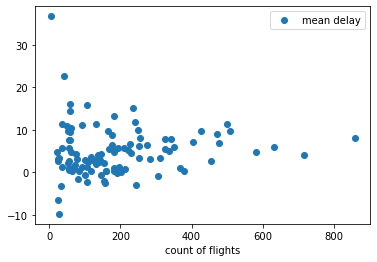

In [11]:
dd.plot(x='count of flights', y='mean delay', style='o')

From the figure above, we can see that there is no clear association between the count of flights and the mean delay. The mean delay appears to be between 0 and 10. There's higher variability for the mean of flights departing to places with a count less than 200. The mean stabilizes as the count increases.

Hence, we have found no clear relation between the departure/arrival locations and the delay of the flights. We cannot make any comments on whether the location has any effect on the delay.

We will now test our second parameter.

### Testing 'day of the week'

In this, we will be checking whether the day of travel has any effect on the delay. For this, we will simply compare the day of the week against the departure delays.

In [8]:
# comparing days of the week by average delay
week = airlines[['DayOfWeek','DepDelay']].groupby('DayOfWeek').agg(['mean','count'])
week.columns = ['mean delay','count of flights']
week.head(7)

,mean delay,count of flights
DayOfWeek,,
1,10.616804,3523
2,8.977292,2334
3,4.589233,2359
4,8.616561,2681
5,7.530108,2873
6,5.931301,2722
7,10.357729,3293


The above data shows that Most flights are on Monday and Sunday. These are also the days that have the most average delays. Hence, as the frequency of flights increase, so do delays.

Airports are usually full close to or over the end of the weekends as that's when most people prefer to travel due to various reasons such as going back home after a business trip or at the end of a leisure trip. This is probably why Sunday and Monday have the highest count of flights (Source - https://simpleflying.com/best-days-to-fly/). 

Now that we've done this, we can move on to the final parameter.

### Testing 'UniqueCarrier'

The next thing we want to check is that whether the carriers have any effect on the delay of the flight. To do this, we first need to identify how many carriers are there in the data. This can be done by counting the number of unique carriers.

In [13]:
# finding number of unique carriers

print("There are {} unique carriers".format(airlines['UniqueCarrier'].nunique()))

There are 14 unique carriers


Once we've found the number of unique carriers, we can go ahead with finding the mean delay and the count of flights corresponding to the carriers. This will help us know how each carrier is performing in handling the delays.

In [4]:
# finding the mean delay and count of flights for UniqueCarrier

carrier = airlines[['UniqueCarrier','DepDelay']].groupby('UniqueCarrier').agg(['mean','count']).sort_values(by=('DepDelay','mean'), ascending=False).reset_index()
carrier.columns = ['UniqueCarrier','mean','count']
carrier['UniqueCarrier'] = carrier['UniqueCarrier'].astype('object') # converting 'UniqueCarrier' type from string to object
carrier.head(14)

,UniqueCarrier,mean,count
0,EV,21.742268,97
1,B6,18.234043,94
2,WN,14.394336,3672
3,MQ,9.901538,325
4,CO,9.881251,6779
5,DL,8.033613,238
6,OO,6.692197,692
7,F9,6.306452,62
8,AA,5.610672,506
9,AS,4.559322,59


At the first look, we can see that EV, B6, and WN have a very high mean delay. Out of these three, only WN's case can be justified as it has a high count of flights too. EV and B6, on the other hand, seem to have high delays despite having an extremely low count of flights. Even F9 and AS seem to be doing not so well, especially when compared to values below them such as XE and US.

To gain further clarification, we will plot this data.

<AxesSubplot:xlabel='UniqueCarrier'>

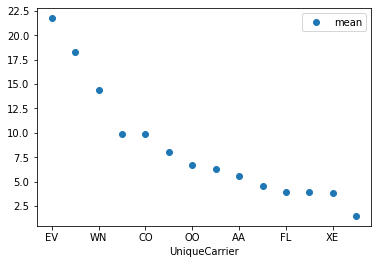

In [8]:
# plotting scatter plot for UniqueCarrier

carrier.plot(x='UniqueCarrier', y='mean', style='o')

Thus, we can see that the type carrier does seem to have a significant impact on the delay. This can be due to some interior issues within the management of the carrier operators, like taking too much time in cleaning the flight once a trip is over, not doing maintenance work on time, not having enough staff to handle required functions, etc.

### Final Analysis

With all the required parameters tested, the final analysis is as follows:

- Overall, the arrival delay is less than the departure delay
- There's no clear relation between the departure/arrival airports and the delay of the flights.
- Monday and Sunday are the busiest time for flights on average, and hence most delays occurring on these days
- Type of carrier seems to have a significant impact on the delay.

### Next Steps

We can use the analysis above to dive deeper into identifying the underlying problems and finding possible solutions for them. For example, further studies would be required to find out why a particular carrier is having problems in beginning their journey on time. This may involve talking to the staff, observing their daily routine, find out if there are any unnecessary actions and remove them to save time, etc.


### Sources -

- Codes source - https://towardsdatascience.com/a-practical-guide-for-exploratory-data-analysis-flight-delays-f8a713ef7121
- Additional codes - https://stackoverflow.com/questions/42832675/setting-axis-labels-for-histogram-pandas
- Additional codes (graphs) - M4 lecture notes
- Additional research - https://medium.com/analytics-vidhya/modeling-flight-delays-through-u-s-flight-data-2f0b3d7e2c89